In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
# build a vocabulary of unique characters and map them from/to integers
chars = sorted(list(set(''.join(words))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}  # 1-indexed
stoi['.'] = 0  
itos = {i: ch for ch, i in stoi.items()}  # 0-indexed
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

# the x contains the context to predict the Y next character; e.g.:
# X[0] = [0, 0, 0] (which are '.') and Y[0] = 1 (which is 'a') meaning that given 
# the context of 3 '.' we predict 'a'

In [12]:
X.shape, X.dtype, Y.shape, Y.dtype
# 228146 = 27*27*27 possible combinations of 3 characters

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [13]:
g = torch.Generator().manual_seed(2147483647) # random seed
# embedding matrix (look up table, 27 rows [one per character] and 2 columns [2D embedding])
C = torch.randn((27, 2), generator=g) 
C

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]])

In [14]:
# VVVVVVVVV
# EMBEDDING
# ^^^^^^^^^

# in order to embed each character (considering its integer representation) we can use the following:
# C[5] => this will give us the 2D embedding of the character with index 5 (preferable to use)
# or we can use the following to produce the same result:
# F.one_hot(torch.tensor(5), num_classes=27) # one-hot encoding

# Indeed, a list can be passed to the embedding matrix to get the corresponding embeddings in one shot:
# (NOTE: embedding in a 2D space is like placing characters in a 2D plane)
emb = C[X] # (228146, 3, 2) => 228146 rows, 3 columns (block size), 2D embedding
emb.shape, emb.dtype

(torch.Size([228146, 3, 2]), torch.float32)

In [15]:
# inputs: 2D embedding * block size => 6*100 (output: 100, taken arbitrarily)
W1 = torch.randn((2*block_size, 100), generator=g) 
# 100 neurons in the hidden layer and 27 neurons in the output layer
b1 = torch.randn((100), generator=g) 

# Now, to perform the matrix multiplication we need to reshape the embedding matrix
# emb @ W1 + b1 => (228146, 3, 2) @ (6, 100) + (100) = (228146, 3, 100)
# but we need to reshape the embedding matrix to (228146, 6) in order to perform the multiplication

# First way: (but does not generalize)
# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape # (228146, 6)

# Second way: (generalizes)
# torch.cat(torch.unbind(emb, 1), dim=1) # (228146, 6)

# Third way: (!best way)
# VIEW: it does not copy the data, it just changes the view of the tensor. This is the most efficient 
# way to reshape a tensor since .storage() (showing the 1D array as stored in memory) is not changed
# emb.view(emb.shape[0], -1) # (228146, 3*2), with -1 we let PyTorch to infer the second dimension

h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) 
h.shape, h.dtype

(torch.Size([228146, 100]), torch.float32)

In [16]:
W2 = torch.randn((100, 27), generator=g) # 100 inputs and 27 outputs (one per each character)
b2 = torch.randn((27), generator=g) # bias for the output layer, 27 as well

logits = h @ W2 + b2 # (228146, 100) @ (100, 27) + (27) = (228146, 27)
# these three lines are equivalent to Cross-Entropy Loss!
#counts = logits.exp()
#probs = counts / counts.sum(1, keepdim=True)
#loss = -probs[torch.arange(logits.shape[0]), Y].log().mean() 
loss = F.cross_entropy(logits, Y) # Cross-Entropy Loss
loss 

tensor(19.5052)

In [33]:
# VVVVVVV
# SUMMARY
# ^^^^^^^

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [38]:
# VVVVVVVVVVVV
# BATCHES SIZE and training loop
# ^^^^^^^^^^^^
# since we are dealing with thousands of parameters, performing forward, backward passes and updates requires
# a lot of time. So, we can use mini-batches to speed up the process.
# Since we are using batches, the quality of gradients is no longer as reliable as before, so we need to
# perform more iterations to get the same quality of gradients.

# VVVVVVVVVVVVVVVVVVVVV
# INITIAL LEARNING RATE determination example 
# ^^^^^^^^^^^^^^^^^^^^^
lre = torch.linspace(-3, 0, 10000) # learning rate range
lrs = 10 ** lre # learning rate

# VVVVVVVVVVVVVVVVVVV
# LEARNING RATE DECAY
# ^^^^^^^^^^^^^^^^^^^
# we can use a learning rate decay to reduce the learning rate as the training progresses
# this is a common practice to avoid overshooting the minimum
# and to help the model converge better.

lri = []
lossi = []
# training loop
for p in parameters:
  p.requires_grad = True 

for i in range(10000):
  # batch size of 32
  ix = torch.randint(0, X.shape[0], (32,)) # random indices

  # forward pass:
  emb = C[X[ix]]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item()) 

  # backward pass:
  for p in parameters:
    p.grad = None 
  loss.backward()

  # update parameters:
  lr = lrs[i]
  lr = 0.1 # gathered by plotting the loss vs learning rate
  for p in parameters: 
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

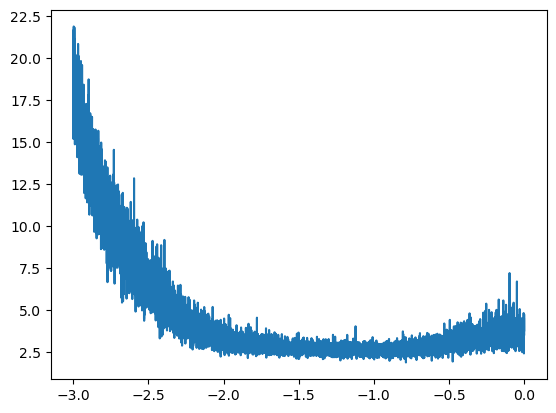

In [36]:
plt.plot(lri, lossi)
# the graph is telling that a reasonable learning rate exponent is between -1.5 and -0.5: let's use 10**-1.0 = 0.1

In [39]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3752, grad_fn=<NllLossBackward0>)

In [40]:
# BUILD TRAIN, VALIDATION AND TESTING SETS

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


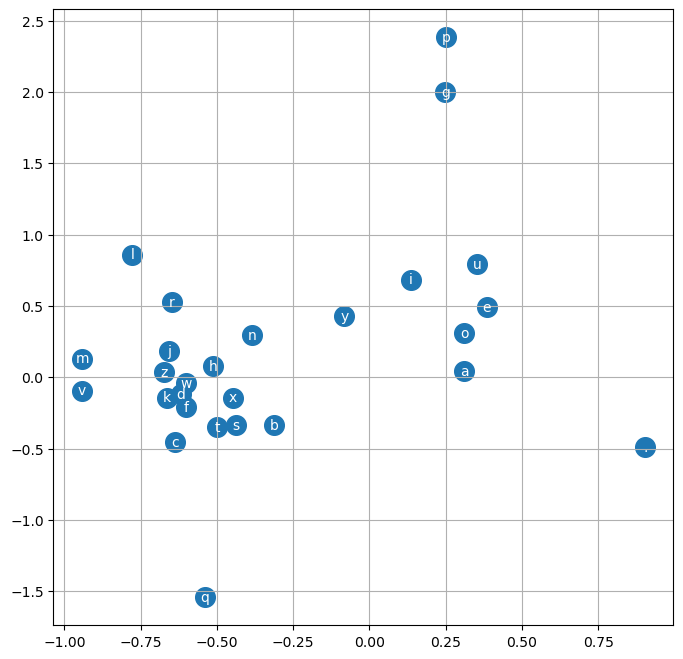

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [45]:
# enlarge embedding size
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

lre = torch.linspace(-3, 0, 10000) # learning rate range
lrs = 10 ** lre # learning rate

lri = []
lossi = []
# training loop
for p in parameters:
  p.requires_grad = True 

for i in range(10000):
  # batch size of 32
  ix = torch.randint(0, X.shape[0], (32,)) # random indices

  # forward pass:
  emb = C[X[ix]]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item()) 

  # backward pass:
  for p in parameters:
    p.grad = None 
  loss.backward()

  # update parameters:
  lr = lrs[i]
  lr = 0.1 # gathered by plotting the loss vs learning rate
  for p in parameters: 
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.log10().item())

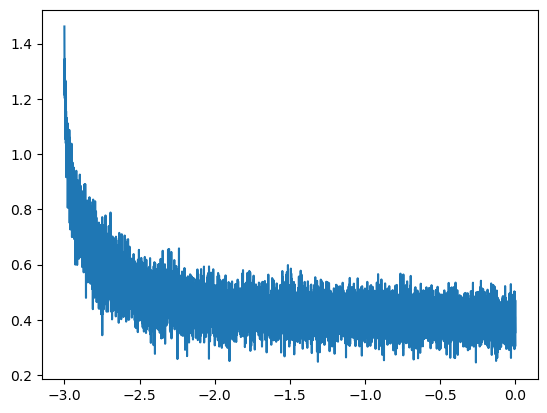

In [46]:
plt.plot(lri, lossi)

In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carla.
zamiyllyah.
jalix.
tatykenanyan.
jazonen.
amlyyat.
areeia.
ramara.
chaiir.
asleigar.
amandin.
quinton.
lalea.
jamii.
wazeron.
jaryxika.
auurinsayley.
eliia.
atasley.
alyah.
